In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, log_loss, confusion_matrix,
    brier_score_loss
)
import joblib
import math
print("Imports done")

data_path = "Salary Data.csv"
df = pd.read_csv(data_path)
print("Loaded:", data_path, " shape:", df.shape)
df.head()


Imports done
Loaded: Salary Data.csv  shape: (375, 6)


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [15]:

df.info()
print("\nMissing values per column:\n", df.isnull().sum())
print("\nUnique counts:\n", df.nunique())


possible = [c for c in df.columns if c.lower() in ("salary","target","label","income","class","y","status")]
if possible:
    target_col = possible[0]
else:

    numeric_candidates = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if "Salary" in df.columns:
        target_col = "Salary"
    elif numeric_candidates:
        target_col = numeric_candidates[0]
    else:

        target_col = df.columns[-1]

print("Selected target column:", target_col)


y_raw = df[target_col]
if pd.api.types.is_numeric_dtype(y_raw) and y_raw.nunique() > 10:
    median_val = y_raw.median()
    print("Binarizing numeric target by median =", median_val)
    df[target_col + "_bin"] = (y_raw > median_val).map({True: "High", False: "Low"})
    target_col = target_col + "_bin"
else:
    df[target_col] = df[target_col].astype(str)

print("Final target:", target_col)
df[[target_col]].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB

Missing values per column:
 Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

Unique counts:
 Age                     31
Gender                   2
Education Level          3
Job Title              174
Years of Experience     28
Salary                  36
dtype: int64
Selected target column: Salary
Binarizing numeric target by

,count
Salary_bin,
Low,199
High,176


In [16]:

df_clean = df.copy()


unique_frac = df_clean.nunique() / len(df_clean)
id_like = unique_frac[unique_frac > 0.95].index.tolist()
if id_like:
    print("Dropping id-like columns:", id_like)
    df_clean = df_clean.drop(columns=id_like)


X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].astype(str)


num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if num_cols:
    X[num_cols] = SimpleImputer(strategy="median").fit_transform(X[num_cols])
if cat_cols:
    X[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[cat_cols])


X_encoded = pd.get_dummies(X, drop_first=True)


le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", list(le.classes_))
print("Feature matrix shape after encoding:", X_encoded.shape)


cleaned_path = "salary_cleaned_for_bdt.csv"
out_df = X_encoded.copy()
out_df[target_col] = y.values
out_df.to_csv(cleaned_path, index=False)
print("Saved cleaned dataset to:", cleaned_path)


Classes: ['High', 'Low']
Feature matrix shape after encoding: (375, 179)
Saved cleaned dataset to: salary_cleaned_for_bdt.csv


In [17]:

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (281, 179) Test shape: (94, 179)


In [18]:

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
proba_gnb = gnb.predict_proba(X_test_scaled)[:, 1] if gnb.predict_proba(X_test_scaled).shape[1] > 1 else gnb.predict_proba(X_test_scaled)[:, 0]
pred_gnb = gnb.predict(X_test_scaled)

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_scaled, y_train)
proba_qda = qda.predict_proba(X_test_scaled)[:, 1] if qda.predict_proba(X_test_scaled).shape[1] > 1 else qda.predict_proba(X_test_scaled)[:, 0]
pred_qda = qda.predict(X_test_scaled)

print("Models trained.")


Models trained.


/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [19]:


from sklearn.metrics import accuracy_score, precision_score

def evaluate_classifier(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
    print("----", model_name, "----")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("--------------------------\n")
    return {"accuracy": acc, "precision": prec}


res_gnb = evaluate_classifier(y_test, pred_gnb, "GaussianNB")
res_qda = evaluate_classifier(y_test, pred_qda, "QDA")


---- GaussianNB ----
Accuracy: 0.723404255319149
Precision: 0.9
--------------------------

---- QDA ----
Accuracy: 0.7127659574468085
Precision: 0.7346938775510204
--------------------------



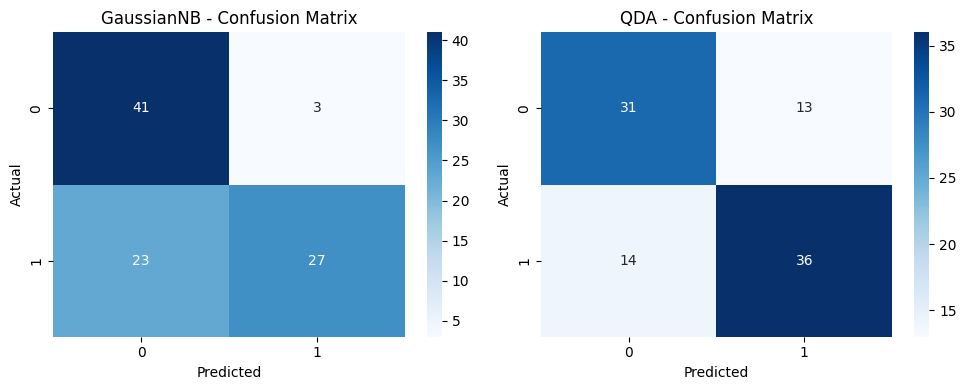

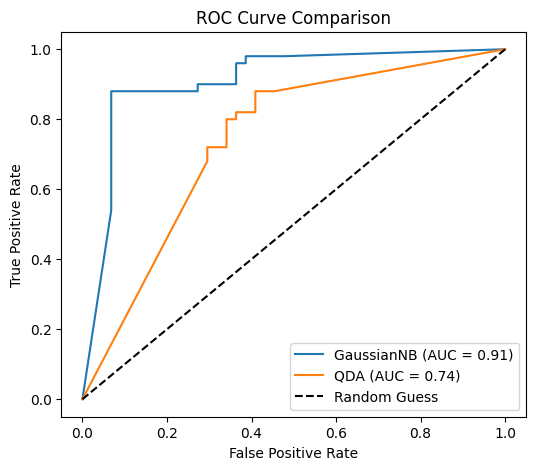

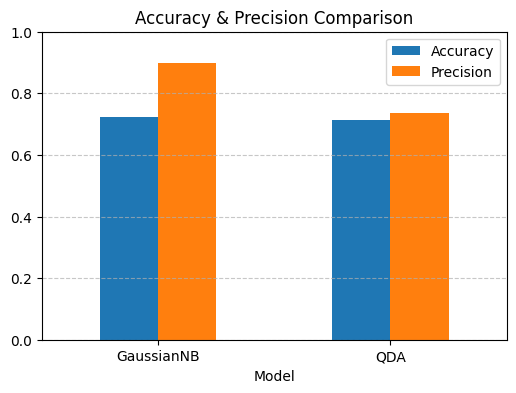

In [20]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, preds, name in zip(axes, [pred_gnb, pred_qda], ["GaussianNB", "QDA"]):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(6, 5))
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, proba_gnb)
fpr_qda, tpr_qda, _ = roc_curve(y_test, proba_qda)
plt.plot(fpr_gnb, tpr_gnb, label=f"GaussianNB (AUC = {auc(fpr_gnb, tpr_gnb):.2f})")
plt.plot(fpr_qda, tpr_qda, label=f"QDA (AUC = {auc(fpr_qda, tpr_qda):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Accuracy & Precision Comparison
metrics = pd.DataFrame({
    "Model": ["GaussianNB", "QDA"],
    "Accuracy": [res_gnb["accuracy"], res_qda["accuracy"]],
    "Precision": [res_gnb["precision"], res_qda["precision"]]
})

metrics.plot(x="Model", kind="bar", figsize=(6,4), rot=0)
plt.title("Accuracy & Precision Comparison")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [21]:

import joblib
import pandas as pd


joblib.dump(gnb, "gnb_model.joblib")
joblib.dump(qda, "qda_model.joblib")
print(" Models saved as: gnb_model.joblib and qda_model.joblib")


summary = pd.DataFrame({
    "Model": ["GaussianNB", "QDA"],
    "Accuracy": [res_gnb["accuracy"], res_qda["accuracy"]],
    "Precision": [res_gnb["precision"], res_qda["precision"]]
})


print("\nModel Summary:")
display(summary)


 Models saved as: gnb_model.joblib and qda_model.joblib

Model Summary:


,Model,Accuracy,Precision
0,GaussianNB,0.723404,0.900000
1,QDA,0.712766,0.734694
